In [49]:
import pandas as pd
df_insurance = pd.read_csv('expenses.csv')
df_insurance.head(20)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


<Axes: >

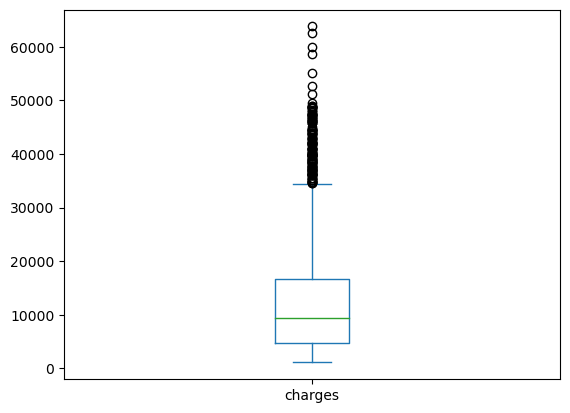

In [50]:
df_insurance.charges.plot(kind='box')

(1338, 7)
(1181, 7)


<Axes: >

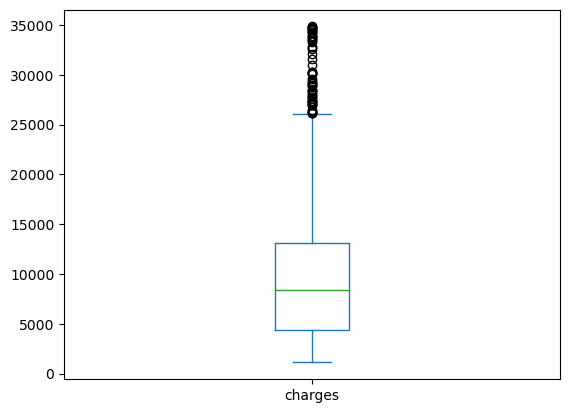

In [51]:
from pandas.api.types import is_numeric_dtype

def remove_outlier(df_in):
  for col in list(df_in.columns):
    if is_numeric_dtype(df_in[col]):
      Q1 = df_in[col].quantile(0.25)
      Q3 = df_in[col].quantile(0.75)
      
      IQR = Q3 - Q1
      low_lim = Q1 - 1.5 * IQR
      up_lim = Q3 + 1.5 * IQR
      
      df_in = df_in.loc[(df_in[col] > low_lim) & (df_in[col] < up_lim)]
      
  return df_in

df_insurance_clean = remove_outlier(df_insurance)
print(df_insurance.shape)
print(df_insurance_clean.shape)
df_insurance_clean.charges.plot(kind='box')

In [52]:
from sklearn.model_selection import train_test_split
X_regress = df_insurance_clean.drop(['charges'], axis=1)
y_regress = df_insurance_clean['charges']

X_train, X_test, y_train, y_test = train_test_split(X_regress, y_regress, test_size=0.25, random_state=0)

In [53]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

cat_cols = ['sex', 'smoker', 'region']

transformer = make_column_transformer((OneHotEncoder(), cat_cols), remainder='passthrough')

X_train_enc = transformer.fit_transform(X_train)
X_test_enc = transformer.transform(X_test)

df_train_enc = pd.DataFrame(X_train_enc, columns=transformer.get_feature_names_out())
df_test_enc = pd.DataFrame(X_test_enc, columns=transformer.get_feature_names_out())

df_train_enc.head()
df_test_enc.head()

,onehotencoder__sex_female,onehotencoder__sex_male,onehotencoder__smoker_no,onehotencoder__smoker_yes,onehotencoder__region_northeast,onehotencoder__region_northwest,onehotencoder__region_southeast,onehotencoder__region_southwest,remainder__age,remainder__bmi,remainder__children
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,33.0,29.400,4.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,64.0,32.965,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,53.0,20.900,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,21.0,25.700,4.0
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,39.0,45.430,2.0


In [54]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

GBR = GradientBoostingRegressor(n_estimators=100, random_state=42).fit(X_train_enc, y_train)

df_result = pd.DataFrame(y_test)
df_result['GBR prediction'] = GBR.predict(X_test_enc)

print("RMSE GBR: ", mean_squared_error(y_test, df_result['GBR prediction'], squared=False))
df_result.head(10)

RMSE GBR:  3916.5566099037433


,charges,GBR prediction
1247,6059.17300,7202.107614
402,14692.66935,14106.548205
793,21195.81800,21400.428761
494,17942.10600,16971.045847
582,6356.27070,7126.494548
792,2731.91220,2987.157638
1268,1880.48700,3223.683112
918,13041.92100,13637.346199
414,2134.90150,2648.751919
728,2217.60120,3180.093193


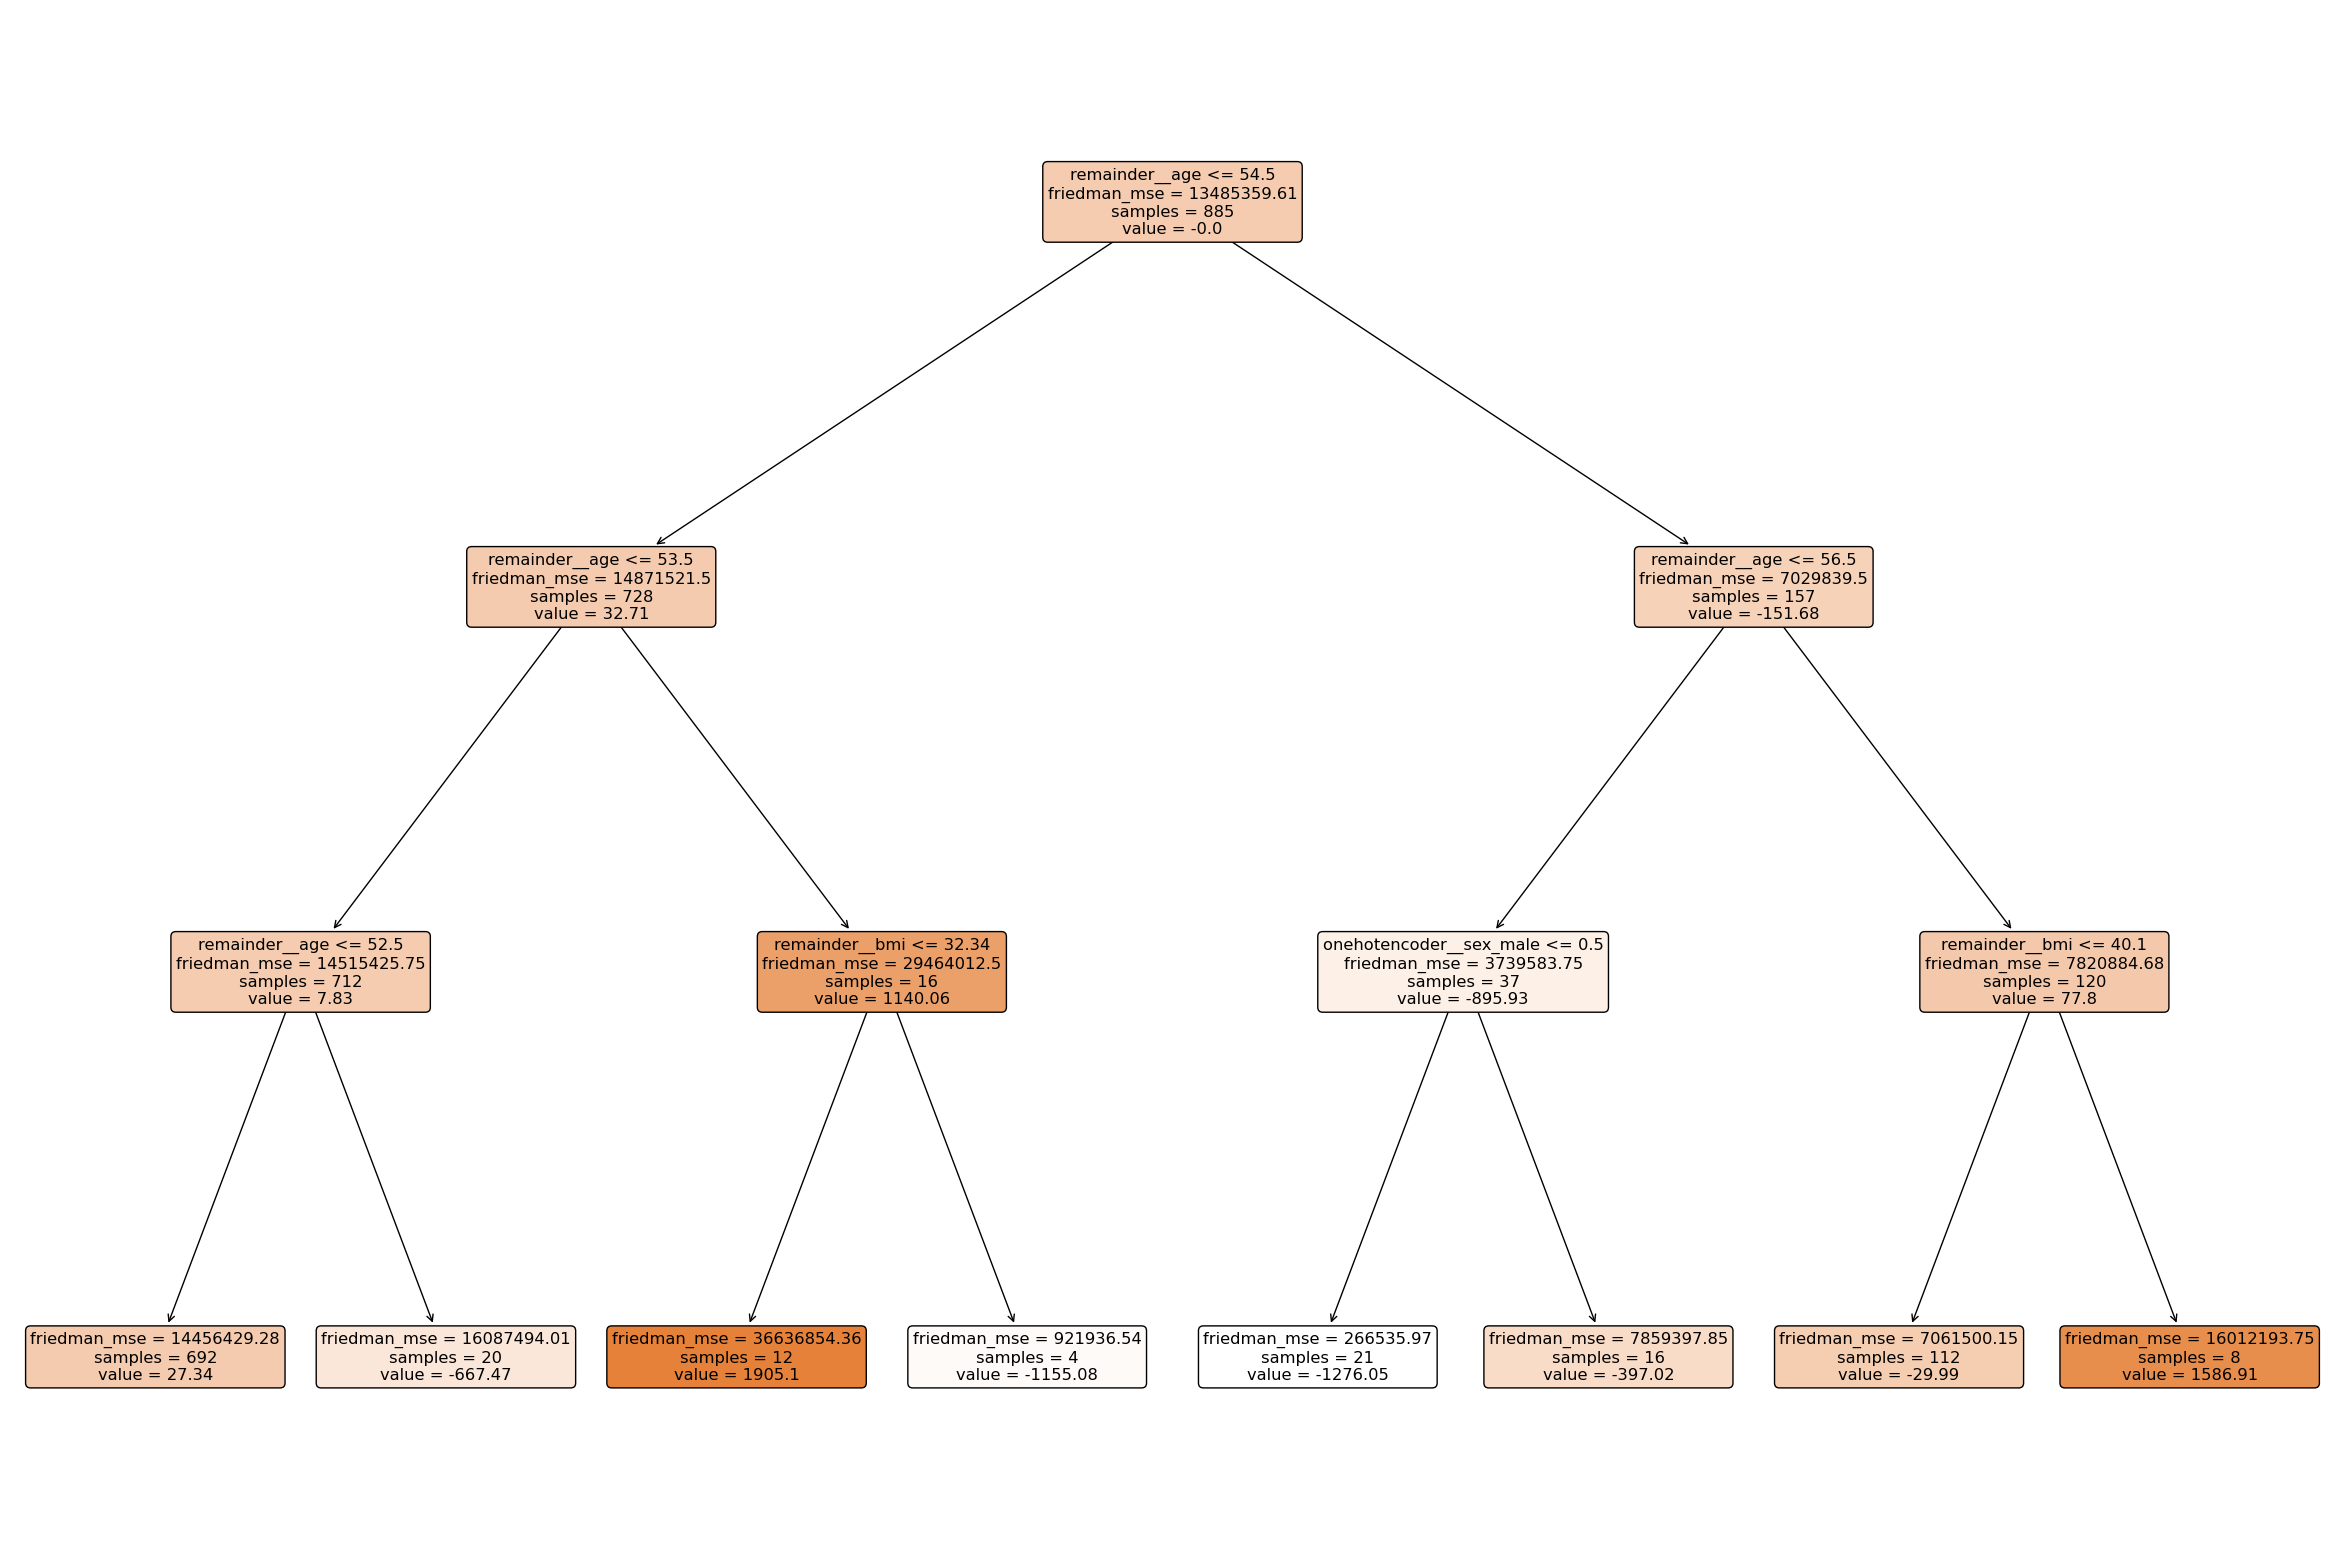

In [55]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(30, 20))
dump = plot_tree(GBR.estimators_[99, 0], feature_names=df_train_enc.columns, filled=True, precision=2, rounded=True)

In [56]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression().fit(X_train_enc, y_train)

print("Koefisien/bobot LR: ", LR.coef_)
print("Intercept LR: ", LR.intercept_)

Koefisien/bobot LR:  [-7.75942518e-01  7.75942518e-01 -7.46029246e+03  7.46029246e+03
  5.47786497e+02  4.47579331e+02 -4.40147683e+02 -5.55218146e+02
  2.39500412e+02  8.78279307e+01  4.99637652e+02]
Intercept LR:  3304.8402475056882


In [57]:
LR_pred = LR.predict(X_test_enc)
df_results['LR prediction'] = LR_pred
df_results.head(10)

NameError: name 'df_results' is not defined